In [1]:
import pandas as pd
import numpy as np
import pandasql as pf
import re
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

from keras.layers import SimpleRNN,LSTM,Conv1D,MaxPooling1D,Dropout, Input, Bidirectional, Activation, Flatten
from keras import regularizers
from keras.layers import BatchNormalization
from keras import optimizers
from keras import initializers
from keras.utils.vis_utils import plot_model

from keras.callbacks import *
from keras import backend as K
import keras 

import tensorflow as tf

from keras.callbacks import *
from keras.optimizers import Adam

In [10]:
df = pd.read_csv('MLDataset_10.csv')

In [14]:
print('Before removing "no subtitles", # records =',len(df))

Before removing "no subtitles", # records = 5806


In [15]:
df = df[df.transcript != "Nosubtitles"]

In [16]:
print('after removing "no subtitles", # records =',len(df))

after removing "no subtitles", # records = 4840


In [17]:
df = df.dropna(subset =['Course'])

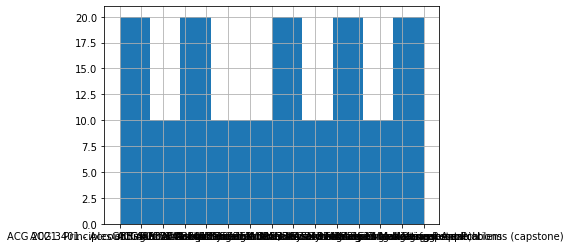

In [91]:
df['Course'].hist()

In [92]:
len(df)

150

In [21]:
test = df.groupby("Course").filter(lambda g: g.Course.size >= 70)

In [22]:
test['Course'].value_counts()

ISM 3011: Information Systems in Organizations                         1860
ACG 2021: Principles of Financial Accounting                            679
GEB 4890 Strategic Management/Executive Decision Making (capstone)      375
ACG 3401 - Accounting Information Systems                               296
MAN 3301: Human Resources Management                                    151
MAN 4737: Integrated Management Applications                            148
ACG 4632 - Audit I                                                      139
MAR 3613 Marketing Research                                             127
CGS 2100 Computers in Business                                          119
ISM 3113: Systems Analysis and Design                                   118
MAR 4824 Marketing Management Problems (capstone)                       112
FIN 4443 Financial Policies and Strategies                              109
CGS2011                                                                  96
ACG3341     

In [23]:
dfsub = test.groupby('Course', group_keys=False).apply(lambda x: x.sample(min(len(x), 10 )))

In [24]:
dfsub['Course'].value_counts()

ACG 2021: Principles of Financial Accounting                           10
ISM 3113: Systems Analysis and Design                                  10
ACG3341                                                                10
CGS 2100 Computers in Business                                         10
FIN 4443 Financial Policies and Strategies                             10
GEB 4890 Strategic Management/Executive Decision Making (capstone)     10
ACG 4632 - Audit I                                                     10
ACG 3401 - Accounting Information Systems                              10
MAR 3613 Marketing Research                                            10
MAN 3301: Human Resources Management                                   10
MAN 4737: Integrated Management Applications                           10
MAR 4824 Marketing Management Problems (capstone)                      10
ISM 3011: Information Systems in Organizations                         10
CGS2011                               

In [122]:
dfsub.to_csv('C:/Users/kavin/CDSdatasetsample.csv')

In [25]:
df = dfsub

Creating X and Y

In [26]:
X = df[['transcript']]
y = df[['Course']]
y_course = df[['Course']]

### Ordinalizing

In [27]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder() 
y = pd.DataFrame(encoder.fit_transform(y), columns=['ordinal'])
y = y.astype(int)

In [28]:
y['ordinal'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [29]:
#Define a pattern

pat1= '#[^ ]+'
pat2 = 'www.[^ ]+'
pat3 = '@[^ ]+'
pat4 = '[0-9]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",   
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}


pattern = '|'.join((pat1,pat2,pat3,pat4))
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

In [30]:
neg_pattern

re.compile(r"\b(isn't|aren't|wasn't|weren't|haven't|hasn't|hadn't|won't|wouldn't|don't|doesn't|didn't|can't|couldn't|shouldn't|mightn't|mustn't)\b",
re.UNICODE)

In [31]:
stop_words = stopwords.words('english')
clean_subs = []


for t in X['transcript']:
    t.lower()
    t = re.sub(pattern,'',t)
    t = neg_pattern.sub(lambda X: negations_dic[X.group()], t)
    t = word_tokenize(t)
    t = [X for X in t if len(X) >1]
    t = [X for X in t if X not in stop_words]
    t = [X for X in t if X.isalpha()]
    t = " ".join(t)
    t = re.sub("n't","not",t)
    t = re.sub("'s","is",t)
    clean_subs.append(t)

In [32]:
X = pd.DataFrame(clean_subs,columns = ['transcript'])

### Tokenizing and padding sequences

In [33]:
tk = Tokenizer(num_words=300)
tk.fit_on_texts(X['transcript'])

df_tok = tk.texts_to_sequences(X['transcript'])
#X_test_tok = tk.texts_to_sequences(X_test)

max_len =300
df_pad = pad_sequences(df_tok, maxlen=max_len, padding = 'post')
#X_test_pad = pad_sequences(X_test_tok, maxlen=max_len)

In [34]:
df_pad

array([[ 84,  19,  11, ...,   0,   0,   0],
       [ 15,  38,  11, ...,   0,   0,   0],
       [ 38,  78,  79, ...,   0,   0,   0],
       ...,
       [ 38, 274,   2, ...,   0,   0,   0],
       [ 64,   6, 176, ..., 232, 161, 103],
       [ 38, 169,  21, ...,   0,   0,   0]])

In [35]:
unique_vocab = len(tk.word_index)
print(unique_vocab)

4504


In [36]:
tk

In [37]:
len(tk.word_index)

4504

### training pre-trained word embedding library with New set of words in data

In [39]:
words_intext = []
for word, i in tk.word_index.items():
    words_intext.append(str(word))

In [40]:
words_intext = [words_intext]

In [41]:
#pip install gensim

In [46]:
from gensim.models import Word2Vec
word2vec_model = Word2Vec(size = 300, window=5,
min_count = 1, workers = 2)
# help(word2vec_model.build_vocab)
word2vec_model.build_vocab(words_intext)
word2vec_model.intersect_word2vec_format('C:/Users/kavin/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)


In [47]:
word2vec_model.train(words_intext, total_examples=1, epochs = 5)

(22520, 22520)

In [49]:
word2vec_model['tableau'].shape

C:\Users\kavin\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(300,)

### Creating the embeddings

In [50]:
embedding_dim = 300

embedding_matrix = np.zeros((unique_vocab+1, embedding_dim)) # intial embedding matrix with zeros \
                                                             #with dim (# of token word , # of features)
# Now get the feature for token words

for word, i in tk.word_index.items():      
    if word in word2vec_model.wv.vocab:
        embedding_matrix[i] = word2vec_model[word]    

C:\Users\kavin\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [51]:
embedding_matrix.shape

(4505, 300)

### Doing cross join on padded dataset

In [52]:
df_pad.shape

(150, 300)

In [53]:
df_pad

array([[ 84,  19,  11, ...,   0,   0,   0],
       [ 15,  38,  11, ...,   0,   0,   0],
       [ 38,  78,  79, ...,   0,   0,   0],
       ...,
       [ 38, 274,   2, ...,   0,   0,   0],
       [ 64,   6, 176, ..., 232, 161, 103],
       [ 38, 169,  21, ...,   0,   0,   0]])

In [54]:
df_pad_df = pd.DataFrame(df_pad)

In [55]:
df_pad_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,84,19,11,40,191,84,214,169,239,76,...,0,0,0,0,0,0,0,0,0,0
1,15,38,11,17,2,27,2,97,30,56,...,0,0,0,0,0,0,0,0,0,0
2,38,78,79,274,147,136,5,126,241,5,...,0,0,0,0,0,0,0,0,0,0
3,131,11,38,147,136,113,113,113,79,84,...,0,0,0,0,0,0,0,0,0,0
4,38,274,78,79,5,126,61,49,16,182,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,131,38,22,28,83,63,13,83,223,28,...,0,0,0,0,0,0,0,0,0,0
146,38,11,148,18,4,48,32,12,40,5,...,0,0,0,0,0,0,0,0,0,0
147,38,274,2,147,136,113,8,274,213,158,...,0,0,0,0,0,0,0,0,0,0
148,64,6,176,176,109,176,31,4,29,40,...,16,16,50,52,84,19,156,232,161,103


In [56]:
df_merged = df_pad_df[df_pad_df.columns[:]].apply(
    lambda x: ','.join(x.astype(str)),
    axis=1
)

In [57]:
df_merged = pd.merge(pd.DataFrame(df_merged),y, left_index=True, right_index=True)

In [58]:
df_merged

,0,ordinal
0,"84,19,11,40,191,84,214,169,239,76,239,16,182,1...",0
1,"15,38,11,17,2,27,2,97,30,56,30,2,23,102,151,23...",0
2,"38,78,79,274,147,136,5,126,241,5,61,32,5,126,6...",0
3,"131,11,38,147,136,113,113,113,79,84,5,177,5,23...",0
4,"38,274,78,79,5,126,61,49,16,182,23,23,23,294,2...",0
...,...,...
145,"131,38,22,28,83,63,13,83,223,28,3,274,147,136,...",14
146,"38,11,148,18,4,48,32,12,40,5,277,92,1,284,4,23...",14
147,"38,274,2,147,136,113,8,274,213,158,158,136,89,...",14
148,"64,6,176,176,109,176,31,4,29,40,4,21,50,47,12,...",14


In [60]:
dfcj = pf.sqldf('''select * from df_merged a,df_merged b''')

In [61]:
dfcj.tail(10)

,0,ordinal,0,ordinal
22490,"38,169,21,156,11,158,18,16,70,71,124,5,40,19,4...",14,"131,38,22,63,63,140,13,101,83,63,140,169,132,1...",14
22491,"38,169,21,156,11,158,18,16,70,71,124,5,40,19,4...",14,"38,5,126,158,37,39,99,19,289,138,25,146,50,50,...",14
22492,"38,169,21,156,11,158,18,16,70,71,124,5,40,19,4...",14,"131,38,5,126,158,148,5,43,43,16,208,158,8,9,1,...",14
22493,"38,169,21,156,11,158,18,16,70,71,124,5,40,19,4...",14,"38,169,268,19,5,5,84,169,229,82,163,22,32,17,3...",14
22494,"38,169,21,156,11,158,18,16,70,71,124,5,40,19,4...",14,"169,21,5,192,6,5,62,4,38,7,85,246,246,116,14,1...",14
22495,"38,169,21,156,11,158,18,16,70,71,124,5,40,19,4...",14,"131,38,22,28,83,63,13,83,223,28,3,274,147,136,...",14
22496,"38,169,21,156,11,158,18,16,70,71,124,5,40,19,4...",14,"38,11,148,18,4,48,32,12,40,5,277,92,1,284,4,23...",14
22497,"38,169,21,156,11,158,18,16,70,71,124,5,40,19,4...",14,"38,274,2,147,136,113,8,274,213,158,158,136,89,...",14
22498,"38,169,21,156,11,158,18,16,70,71,124,5,40,19,4...",14,"64,6,176,176,109,176,31,4,29,40,4,21,50,47,12,...",14
22499,"38,169,21,156,11,158,18,16,70,71,124,5,40,19,4...",14,"38,169,21,156,11,158,18,16,70,71,124,5,40,19,4...",14


In [62]:
dfcj['similar'] = np.where(dfcj.iloc[:,1] == dfcj.iloc[:,3] , 1, 0)

In [64]:
dfcj = dfcj.drop(['ordinal'], axis = 1)

### Create train and test

In [65]:
X_train, X_test, y_train, y_test = train_test_split(dfcj.iloc[:,0:2], dfcj['similar'], test_size=0.3, random_state=42,stratify=dfcj['similar'])

In [66]:
X_train

,0,0
20240,"38,274,196,21,5,290,249,21,7,85,160,22,249,256...","131,38,22,63,63,140,13,101,83,63,140,169,132,1..."
16193,"131,38,19,11,1,5,126,165,16,11,280,167,91,11,3...","38,169,268,19,5,5,84,169,229,82,163,22,32,17,3..."
17473,"15,11,259,37,17,73,50,5,16,263,136,149,142,18,...","131,38,19,156,196,169,177,253,214,82,19,14,16,..."
12456,"259,289,17,17,94,83,5,25,5,70,71,62,25,3,124,8...","38,43,61,2,46,164,133,2,294,30,17,30,2,30,2,23..."
15226,"131,38,13,13,140,44,83,223,28,101,196,11,19,15...","38,19,11,109,185,43,1,17,25,185,79,97,79,109,3..."
...,...,...
11153,"131,70,71,56,169,37,19,17,116,17,19,5,15,5,38,...","70,71,19,214,141,5,116,70,71,19,70,71,96,34,49..."
2942,"131,38,147,136,22,44,3,83,3,44,28,156,74,32,84...","79,44,2,79,134,3,3,100,54,2,20,124,95,67,123,1..."
4740,"230,5,52,24,116,132,170,258,24,5,20,162,231,39...","12,215,199,110,192,25,158,91,10,68,261,21,263,..."
10157,"133,5,277,25,17,24,177,24,1,45,29,108,257,177,...","131,38,19,11,1,5,126,165,16,11,280,167,91,11,3..."


In [67]:
x1_train = X_train.iloc[:,0].str.split(',', expand=True).values
x2_train = X_train.iloc[:,1].str.split(',', expand=True).values
x1_test = X_test.iloc[:,0].str.split(',', expand=True).values
x2_test = X_test.iloc[:,1].str.split(',', expand=True).values

In [68]:
print(x1_train.shape)
print(x2_train.shape)
print(x1_test.shape)
print(x2_test.shape)
print(y_train.shape)
print(y_test.shape)

(15750, 300)
(15750, 300)
(6750, 300)
(6750, 300)
(15750,)
(6750,)


In [100]:
x2_test.dtype

dtype('int32')

In [87]:
x1_train = x1_train.astype(int)
x2_train = x2_train.astype(int)
x1_test = x1_test.astype(int)
x2_test = x2_test.astype(int)

### Euclidean distance

In [69]:
def euclidean_distance(output):
    x, y = output[0],output[1]
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

### LSTM Siamese Network

In [71]:

def lstm_model(input_shape,embedding_matrix,embedding_dim):
  model_input = Input(shape=(input_shape,))
  layer = Embedding(input_dim=unique_vocab+1, output_dim=embedding_dim, input_length=max_len,
                    weights=[embedding_matrix],trainable=False)(model_input)
  layer = Bidirectional(LSTM(30, return_sequences=True))(layer)
  layer = Bidirectional(LSTM(10))(layer)        
  layer = Dense(15)(layer)
  output = Flatten()(layer)
  
  model = Model(inputs=model_input, outputs=output)
  model.summary()
  return model

In [72]:
model = lstm_model(max_len,embedding_matrix,embedding_dim)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 300)          1351500   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 60)           79440     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                5680      
_________________________________________________________________
dense (Dense)                (None, 15)                315       
_________________________________________________________________
flatten (Flatten)            (None, 15)                0         
Total params: 1,436,935
Trainable params: 85,435
Non-trainable params: 1,351,500
_______________________________________

In [73]:
emb = Embedding(input_dim=unique_vocab+1, output_dim=embedding_dim, input_length=max_len,
                    weights=[embedding_matrix],trainable=False)

In [74]:
input_q1 = Input(shape=(max_len,))
e1 = emb(input_q1)
layer1_1 = Bidirectional(LSTM(30, return_sequences=True))(e1)
x1 = Bidirectional(LSTM(10))(layer1_1)                              
                      
input_q2 = Input(shape=(max_len,))
e2 = emb(input_q2)
layer1_2 = Bidirectional(LSTM(30, return_sequences=True))(e2)
x2 = Bidirectional(LSTM(10))(layer1_2)  

In [75]:
mhd = lambda x: tf.keras.backend.abs(x[0] - x[1])
merged = tf.keras.layers.Lambda(function=mhd, output_shape=lambda x: x[0],
name='L1_distance')([x1, x2])
preds = tf.keras.layers.Dense(1, activation='sigmoid')(merged)
model = tf.keras.Model(inputs=[input_q1, input_q2], outputs=preds)

In [76]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     1351500     input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 300, 60)      79440       embedding_1[0][0]     

In [78]:
model.compile(loss="mean_squared_error",optimizer="adam",metrics=['accuracy'])

In [88]:
history = model.fit([x1_train,x2_train],
                    y_train,
                    epochs=10,
                    validation_split=0.1
                   )

Epoch 1/10
443/443 [==============================] - 115s 259ms/step - loss: 0.0728 - accuracy: 0.9234 - val_loss: 0.0628 - val_accuracy: 0.9327
Epoch 2/10
443/443 [==============================] - 118s 265ms/step - loss: 0.0623 - accuracy: 0.9334 - val_loss: 0.0628 - val_accuracy: 0.9327
Epoch 3/10
443/443 [==============================] - 100s 227ms/step - loss: 0.0622 - accuracy: 0.9334 - val_loss: 0.0628 - val_accuracy: 0.9327
Epoch 4/10
443/443 [==============================] - 106s 240ms/step - loss: 0.0622 - accuracy: 0.9334 - val_loss: 0.0628 - val_accuracy: 0.9327
Epoch 5/10
443/443 [==============================] - 127s 288ms/step - loss: 0.0621 - accuracy: 0.9334 - val_loss: 0.0626 - val_accuracy: 0.9327
Epoch 6/10
443/443 [==============================] - 126s 285ms/step - loss: 0.0620 - accuracy: 0.9334 - val_loss: 0.0626 - val_accuracy: 0.9327
Epoch 7/10
443/443 [==============================] - 181s 408ms/step - loss: 0.0618 - accuracy: 0.9334 - val_loss: 0.0626 -

In [94]:
y_pred = model.predict([x1_test,x2_test])

In [101]:
results = model.evaluate([x1_test,x2_test],y_test,batch_size=50)

135/135 [==============================] - 48s 354ms/step - loss: 0.0613 - accuracy: 0.9333


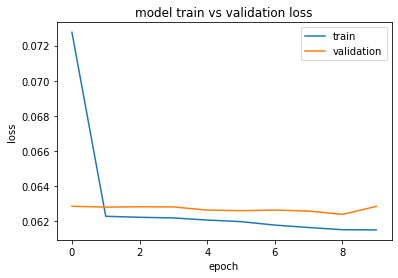

In [102]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'])
pyplot.show()

#### Saving the model

In [112]:
import os.path
if os.path.isfile('C:/Users/kavin/CDSmodels/siamesemodel1.h5') is False:
    model.save('C:/Users/kavin/CDSmodels/siamesemodel1.h5')

In [113]:
from tensorflow.keras.models import load_model
new_model = load_model('C:/Users/kavin/CDSmodels/siamesemodel1.h5')